In [ ]:
import pandas as pd

# Chargement des fichiers CSV
critic_reviews_df = pd.read_csv('/content/reviews_realcomplete.csv')


# Affichage des premières lignes de chaque DataFrame pour examiner leur structure
(critic_reviews_df .head())


In [41]:
(critic_reviews_df .head())

primary_genre critic_sex
0        Action       Male
1        Action     Female
2       Romance     Female
3        Action       Male
4       Romance       Male

In [22]:
critic_reviews_df.columns


Index(['rotten_tomatoes_link', 'critic_name', 'top_critic', 'publisher_name',
       'review_type', 'review_score', 'review_date', 'review_content',
       'movie_title', 'movie_info', 'critics_consensus', 'content_rating',
       'genres', 'directors', 'authors', 'actors', 'original_release_date',
       'streaming_release_date', 'runtime', 'production_company',
       'tomatometer_status', 'tomatometer_rating', 'tomatometer_count',
       'audience_status', 'audience_rating', 'audience_count',
       'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count',
       'tomatometer_rotten_critics_count', 'sentiment', 'primary_genre'],
      dtype='object')

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor


# Sélectionner les caractéristiques et la cible
features = ['tomatometer_rating', 'tomatometer_count', 'primary_genre']
target = 'audience_rating'

# Séparer les caractéristiques et la cible
X = critic_reviews_df[features]
y = critic_reviews_df[target]

# Gestion des valeurs manquantes pour les caractéristiques numériques
num_features = ['tomatometer_rating', 'tomatometer_count']
num_transformer = SimpleImputer(strategy='median')

# Gestion des valeurs manquantes et encodage pour les caractéristiques catégorielles
cat_features = ['primary_genre']
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Préprocesseur pour transformer les données
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

# Diviser les données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Prétraitement terminé.")



Prétraitement terminé.


In [10]:
# Supprimer les lignes où la cible (audience_rating) est NaN
data_clean = critic_reviews_df.dropna(subset=[target])

# Séparer les caractéristiques et la cible après nettoyage
X = data_clean[features]
y = data_clean[target]

# Diviser les données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Puis, reprenez l'entraînement du modèle comme précédemment



In [11]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score

# Suppression des valeurs manquantes dans la variable cible
data_clean = critic_reviews_df.dropna(subset=[target])

# Séparation des caractéristiques et de la cible dans les données nettoyées
X = data_clean[features]
y = data_clean[target]

# Division des données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configuration du modèle XGBoost avec des paramètres initiaux
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Création du pipeline avec le préprocesseur et le modèle XGBoost
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', xgb_model)])

# Entraînement du modèle sur l'ensemble d'apprentissage
pipeline.fit(X_train, y_train)

# Évaluation du modèle sur l'ensemble de test
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE sur l'ensemble de test: {mae:.2f}")

# Optionnel: Évaluation croisée pour une estimation plus robuste de la performance du modèle
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -1 * cv_scores.mean()
print(f"Moyenne MAE via validation croisée: {cv_mae:.2f}")


MAE sur l'ensemble de test: 5.05
Moyenne MAE via validation croisée: 11.34


In [12]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Définition de la grille de recherche
param_grid = {
    'model__n_estimators': np.arange(50, 400, 50),
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__max_depth': np.arange(3, 10, 1),
    'model__min_child_weight': [1, 2, 3, 4]
}

# Configuration de RandomizedSearchCV
search_cv = RandomizedSearchCV(pipeline, param_grid, n_iter=10, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=42)

# Lancement de la recherche
search_cv.fit(X_train, y_train)

# Meilleurs paramètres et score correspondant
print("Meilleurs paramètres:", search_cv.best_params_)
print("Meilleur score MAE (validation croisée):", -search_cv.best_score_)


Meilleurs paramètres: {'model__n_estimators': 350, 'model__min_child_weight': 1, 'model__max_depth': 9, 'model__learning_rate': 0.01}
Meilleur score MAE (validation croisée): 4.050513325443997


In [13]:
# Réinitialisation du modèle avec les meilleurs hyperparamètres trouvés
optimized_model = XGBRegressor(
    n_estimators=350,
    min_child_weight=1,
    max_depth=9,
    learning_rate=0.01,
    random_state=42
)

# Création du pipeline avec le modèle optimisé
optimized_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('model', optimized_model)])

# Réentraînement du modèle sur l'ensemble d'apprentissage complet
optimized_pipeline.fit(X_train, y_train)

# Évaluation du modèle optimisé sur l'ensemble de test
optimized_predictions = optimized_pipeline.predict(X_test)
optimized_mae = mean_absolute_error(y_test, optimized_predictions)
print(f"MAE optimisé sur l'ensemble de test: {optimized_mae:.2f}")


MAE optimisé sur l'ensemble de test: 4.05


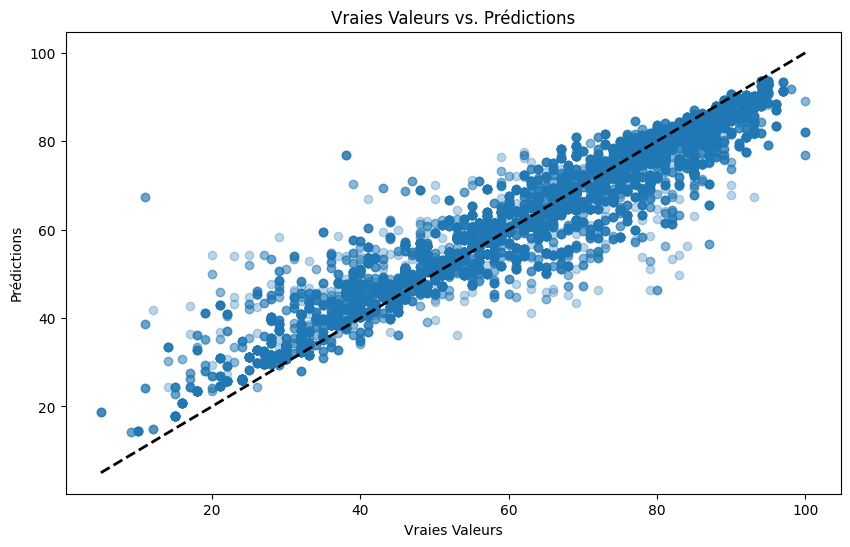

In [14]:
import matplotlib.pyplot as plt

# Prédire les valeurs d'audience_rating sur l'ensemble de test
y_pred_optimized = optimized_pipeline.predict(X_test)

# Création du graphique
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_optimized, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Ligne pour les prédictions parfaites
plt.xlabel('Vraies Valeurs')
plt.ylabel('Prédictions')
plt.title('Vraies Valeurs vs. Prédictions')
plt.show()


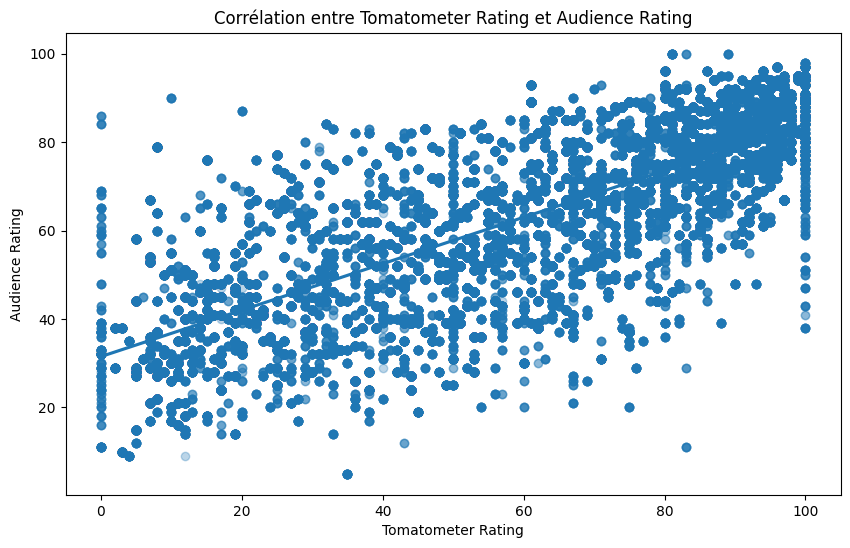

Corrélation entre Tomatometer Rating et Audience Rating:
                     tomatometer_rating  audience_rating
tomatometer_rating            1.000000         0.746956
audience_rating               0.746956         1.000000


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Chargement des données
critic_reviews_df = pd.read_csv('/content/reviews_realcomplete.csv')

# Assurons-nous que les scores sont numériques
critic_reviews_df['tomatometer_rating'] = pd.to_numeric(critic_reviews_df['tomatometer_rating'], errors='coerce')
critic_reviews_df['audience_rating'] = pd.to_numeric(critic_reviews_df['audience_rating'], errors='coerce')

# Scatter plot avec ligne de régression
plt.figure(figsize=(10, 6))
sns.regplot(x='tomatometer_rating', y='audience_rating', data=critic_reviews_df, scatter_kws={'alpha':0.3})
plt.title('Corrélation entre Tomatometer Rating et Audience Rating')
plt.xlabel('Tomatometer Rating')
plt.ylabel('Audience Rating')
plt.show()

# Calcul de la corrélation
correlation = critic_reviews_df[['tomatometer_rating', 'audience_rating']].corr()
print("Corrélation entre Tomatometer Rating et Audience Rating:\n", correlation)



In [37]:
pip install gender-guesser


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 kB 6.8 MB/s eta 0:00:00


In [38]:
import gender_guesser.detector as gender
d = gender.Detector()
critic_reviews_df['critic_sex'] = critic_reviews_df['critic_name'].apply(lambda x: d.get_gender(x.split()[0]))

import plotly.express as px

# Assurons-nous d'avoir 'Male' et 'Female' comme seuls sexes pour la simplicité de l'exemple
# critic_reviews_df = critic_reviews_df[critic_reviews_df['critic_sex'].isin(['male', 'female'])]

# Compter le nombre de critiques par genre et par sexe
critique_counts = critic_reviews_df.groupby(['primary_genre', 'critic_sex']).size().reset_index(name='counts')

# Créer la visualisation
fig = px.bar(critique_counts, x='primary_genre', y='counts', color='critic_sex', barmode='group',
             title="Influence des Genres de Films sur le Sexe du Journaliste Critique",
             labels={'counts': 'Nombre de Critiques', 'primary_genre': 'Genre de Film', 'critic_sex': 'Sexe du Critique'})

# Afficher le graphique
fig.show()



KeyError: 'critic_name'

In [30]:
import plotly.express as px

# Assurons-nous que votre DataFrame est chargé
# critic_reviews_df = pd.read_csv('/chemin/vers/votre/fichier.csv')

# Création d'un scatter plot interactif sans référencer de colonnes inexistantes
fig = px.scatter(
    critic_reviews_df,
    x='tomatometer_rating',  # Score du Tomatometer
    y='audience_rating',     # Score de l'audience
    # Supprimer ou remplacer 'budget' par une colonne existante dans votre DataFrame, si disponible
    # color='budget',
    # Supprimer ou remplacer 'num_reviews' par une colonne existante dans votre DataFrame, si disponible
    # size='num_reviews',
    hover_name='movie_title',  # Nous supposons que cette colonne existe
    title='Corrélation entre Tomatometer Rating et Audience Rating',
    labels={'tomatometer_rating': 'Tomatometer Rating', 'audience_rating': 'Audience Rating'}
)

# Ajout d'une ligne de tendance avec l'intervalle de confiance
fig.add_traces(px.scatter(
    critic_reviews_df,
    x='tomatometer_rating',
    y='audience_rating',
    trendline='ols',  # Ordinary Least Squares pour la régression
    trendline_color_override='black'
).data)

# Amélioration du layout
fig.update_layout(
    hovermode='closest',
    plot_bgcolor='white',
    xaxis=dict(title='Tomatometer Rating', gridcolor='lightgrey'),
    yaxis=dict(title='Audience Rating', gridcolor='lightgrey')
)

# Mise à jour des axes pour une meilleure lisibilité
fig.update_xaxes(zeroline=True, zerolinewidth=2, zerolinecolor='LightPink')
fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='LightPink')

# Affichage du graphique
fig.show()



In [36]:
import pandas as pd
import plotly.express as px

# Chargement des données
critic_reviews_df = pd.read_csv('/content/reviews_realcomplete.csv')

# Assurez-vous que 'tomatometer_rating' et 'audience_rating' sont numériques
critic_reviews_df['tomatometer_rating'] = pd.to_numeric(critic_reviews_df['tomatometer_rating'], errors='coerce')
critic_reviews_df['audience_rating'] = pd.to_numeric(critic_reviews_df['audience_rating'], errors='coerce')

# Simplification des genres pour la visualisation (à adapter en fonction de vos données)
# Si 'genres' est une colonne contenant des listes de genres, nous pourrions vouloir prendre le premier genre mentionné comme représentant principal
critic_reviews_df['primary_genre'] = critic_reviews_df['genres'].str.split(',').str[0]

# Graphique pour Tomatometer Rating par genre de film
fig1 = px.box(
    critic_reviews_df,
    x='primary_genre',
    y='tomatometer_rating',
    color='primary_genre',
    title="Distribution des Scores du Tomatometer par Genre de Film",
    labels={'primary_genre': 'Genre de Film', 'tomatometer_rating': 'Tomatometer Rating'}
)
fig1.update_layout(showlegend=False)
fig1.show()

# Graphique pour Audience Rating par genre de film
fig2 = px.box(
    critic_reviews_df,
    x='primary_genre',
    y='audience_rating',
    color='primary_genre',
    title="Distribution des Scores d'Audience par Genre de Film",
    labels={'primary_genre': 'Genre de Film', 'audience_rating': 'Audience Rating'}
)
fig2.update_layout(showlegend=False)
fig2.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Load your data
# critic_reviews_df = pd.read_csv("path_to_your_file.csv")

# Définition des caractéristiques et de la cible
features = ['tomatometer_rating', 'sentiment', 'primary_genre', 'review_content']
target = 'audience_rating'

# Nettoyage des données
# S'assurer que toutes les valeurs de 'features' et 'target' ne sont pas NaN
data_clean = critic_reviews_df.dropna(subset=features + [target])

# Conversion de 'audience_rating' en float pour éviter des problèmes lors de l'utilisation avec XGBRegressor
data_clean[target] = data_clean[target].astype(float)

X = data_clean[features]
y = data_clean[target]

# Prétraitement des caractéristiques numériques
num_features = ['tomatometer_rating']
num_transformer = SimpleImputer(strategy='median')

# Prétraitement des caractéristiques catégorielles
cat_features = ['sentiment', 'primary_genre']
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Gestion des valeurs manquantes
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encodage OneHot
])

# Prétraitement des critiques textuelles
text_feature = 'review_content'
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words='english'))  # Vectorisation TF-IDF
])

# Création du préprocesseur avec ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features),
        ('text', text_transformer, [text_feature])  # Passez une liste même pour une seule colonne
    ])

# Pipeline complet avec XGBRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

# Division des données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement du modèle
pipeline.fit(X_train, y_train)

# Évaluation du modèle
predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"MAE: {mae}")


# Create the graph to visualize true values vs predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Line for perfect predictions
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs. Predictions')
plt.show()


# Interprétation :
#Votre modèle utilise l'apprentissage automatique (machine learning) pour prédire l'audience_rating
#(le score de satisfaction du public) en fonction de plusieurs caractéristiques,
#notamment les scores des critiques sur le Tomatometer (tomatometer_rating, tomatometer_count),
#le genre principal du film (primary_genre), et l'analyse textuelle des critiques (review_content).
#Le modèle essaie de trouver des motifs et des relations entre ces caractéristiques et l'audience_rating,
#permettant de faire des prédictions sur de nouvelles données non vues lors de l'entraînement.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Supposons que vous ayez déjà chargé votre DataFrame dans `critic_reviews_df`

# Préparation des données
data = critic_reviews_df.copy()
data.dropna(subset=['audience_rating'], inplace=True)  # Supprimer les lignes où audience_rating est NaN
data['audience_rating'] = data['audience_rating'].astype(float)  # Convertir audience_rating en float

# Sélection des caractéristiques
features = ['tomatometer_rating', 'sentiment', 'primary_genre', 'review_content']
X = data[features]
y = data['audience_rating']

# Définir le préprocesseur
num_features = ['tomatometer_rating']
cat_features = ['sentiment', 'primary_genre']
text_features = ['review_content']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('text', TfidfVectorizer(stop_words='english'), text_features[0])
    ])

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

# Division des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement du modèle
pipeline.fit(X_train, y_train)

# Évaluation du modèle
predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"MAE: {mae}")

# Interprétation :
#Ce modèle utilise l'apprentissage automatique pour prédire la satisfaction du public
#envers des films, mesurée par l'audience_rating, en se basant sur les scores Tomatometer,
#le genre du film, et une analyse de sentiment des critiques journalistiques.
#L'ajout de l'analyse de sentiment vise à comprendre les nuances
#émotionnelles des critiques, offrant ainsi une perspective plus riche sur
#les réactions potentielles du public. L'objectif est de fournir des prédictions
#précises sur la réception d'un film, enrichies par une compréhension profonde à la fois des aspects quantitatifs et qualitatifs des critiques.
#Avec un MAE de 7.89, le modèle montre qu'en moyenne,
#ses prédictions sur la satisfaction du public peuvent
#s'écarter de près de 8 points sur l'échelle de notation réelle(notation de jusuq a 100), indiquant une précision raisonnable et assez bonne
#mais avec une marge d'amélioration notable ( = améliorer le modele optimiser dans le futur)
#modele final

NameError: name 'critic_reviews_df' is not defined

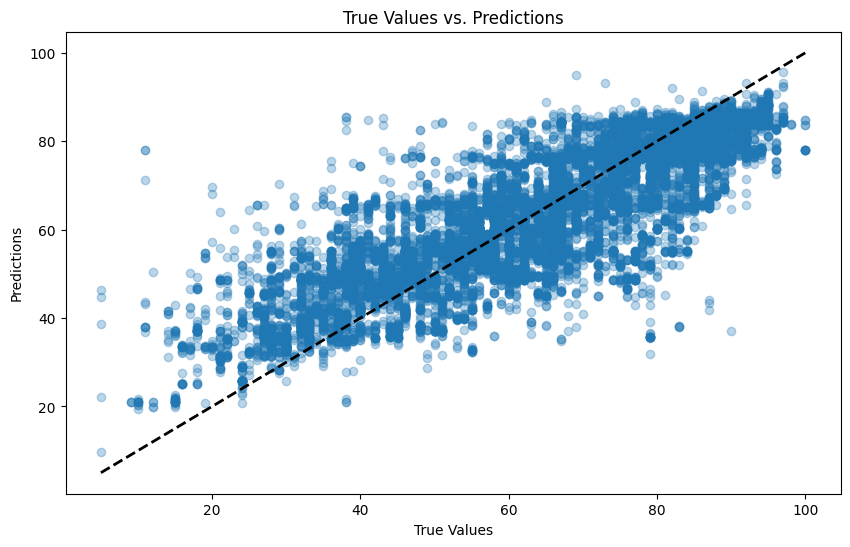

In [27]:
# Create the graph to visualize true values vs predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Line for perfect predictions
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs. Predictions')
plt.show()

In [28]:
import plotly.graph_objects as go

# Création du graphique pour visualiser les vraies valeurs vs les prédictions avec Plotly
fig = go.Figure()

# Ajout des points de prédiction
fig.add_trace(go.Scatter(x=y_test, y=predictions, mode='markers', name='Predictions',
                         marker=dict(color='blue', opacity=0.3)))

# Ajout de la ligne pour les prédictions parfaites
fig.add_trace(go.Scatter(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()],
                         mode='lines', name='Perfect Prediction',
                         line=dict(color='black', dash='dash')))

# Mise en forme du graphique
fig.update_layout(title='True Values vs. Predictions',
                  xaxis_title='True Values',
                  yaxis_title='Predictions',
                  plot_bgcolor='white')

fig.show()
##modele final

MAE: 6.194838733961215


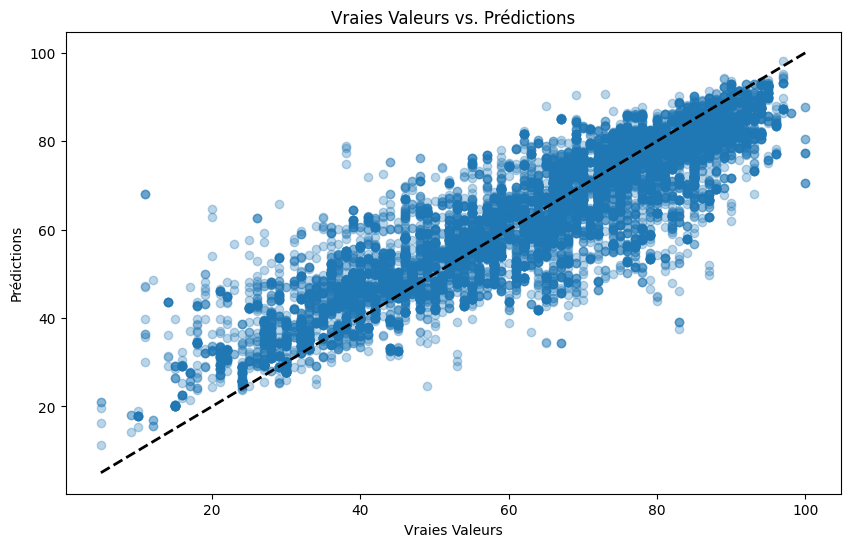

In [9]:
# Évaluation du modèle
predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")
# Création du graphique pour visualiser les vraies valeurs vs les prédictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Ligne pour les prédictions parfaites
plt.xlabel('Vraies Valeurs')
plt.ylabel('Prédictions')
plt.title('Vraies Valeurs vs. Prédictions')
plt.show()

#Interprétation ;
#Le graphique que nous voyons représente
#l'efficacité de notre modèle prédictif en analysant non seulement le contenu textuel des critiques de films, mais aussi en intégrant des paramètres quantitatifs tels que les notes des critiques professionnelles et la quantité de ces critiques. Notre objectif est de prédire la satisfaction de l'audience, représentée ici par les points bleus, chaque point indiquant la prédiction du modèle par rapport à la note réelle donnée par l'audience.
#Le MAE de 6.19 nous indique que, bien que nos prédictions ne soient pas parfaites,
#elles sont en moyenne relativement proches des vraies valeurs, avec un écart moyen un peu plus de 6 points sur une échelle allant jusqu'à 100. Ce niveau d'erreur peut être considéré comme acceptable dans une phase initiale de modélisation, surtout compte tenu de la complexité inhérente à l'interprétation des critiques textuelles et à la prédiction des sentiments humains.
#En examinant le graphique, nous pouvons constater que beaucoup de prédictions sont alignées près de la ligne en pointillés,
#qui représenterait une correspondance parfaite entre les prédictions et les vraies valeurs.
#Cependant, la dispersion des points, en particulier autour des scores moyens,
#suggère que notre modèle pourrait être affiné. Cela pourrait impliquer d'explorer plus en profondeur le traitement linguistique des critiques,
#ou de considérer d'autres caractéristiques qui pourraient influencer la satisfaction de l'audience,
#comme le genre du film, la présence de certaines stars, ou le contexte culturel du moment.
#En somme, notre analyse textuelle, enrichie par des données quantitatives supplémentaires,
#fournit une base solide pour prédire la réception d'un film par son public.
#L'objectif pour la suite sera d'optimiser notre modèle pour minimiser les écarts et améliorer la précision de nos prédictions."




In [42]:
# Initialisation du détecteur de genre
d = gender.Detector()

# Extraction du premier nom et déduction du genre
critic_reviews_df['first_name'] = critic_reviews_df['critic_name'].str.split().str[0]
critic_reviews_df['gender'] = critic_reviews_df['first_name'].apply(lambda x: d.get_gender(x))

# Nettoyage des résultats de genre (optionnel)
critic_reviews_df['gender'] = critic_reviews_df['gender'].replace({'mostly_male': 'male', 'mostly_female': 'female', 'andy': 'unknown'})
# a faire sur les acteurs pas ca a cause des unkwnonwn




KeyError: 'critic_name'